# Automatyczne różniczkowanie - tryb w przód

In [1]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

In [2]:
import Base: +, -, *, /

-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

/ (generic function with 107 methods)

In [3]:
import Base: abs, sin, cos, tan, exp, sqrt, isless 

abs(x::Dual)  = Dual(abs(x.v),  sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v),   cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),  -sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v),   one(x.v)*x.dv + tan(x.v)^2*x.dv) 
exp(x::Dual)  = Dual(exp(x.v),   exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v), .5/sqrt(x.v) * x.dv) 
isless(x::Dual, y::Dual) = x.v < y.v;

In [4]:
import Base: show

show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]"); 
value(x::Dual)    = x.v;
partials(x::Dual) = x.dv;

In [5]:
import Base: convert, promote_rule 

convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

promote_rule (generic function with 125 methods)

In [6]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

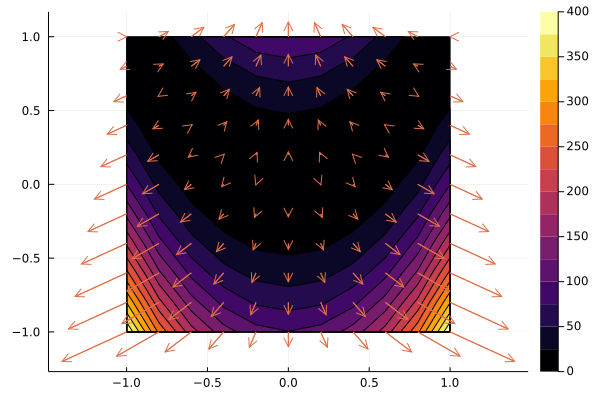

In [7]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x)
himmelblau(x, y) = (x*x + y - 11)*(x*x + y - 11) + (x + y*y - 7)*(x + y*y - 7)

ε = Dual(0., 1.);
v = -1:.2:+1
n = length(v)
xv = repeat(v, inner=n) 
yv = repeat(v, outer=n)

z = rosenbrock.(xv .+ ε, yv)
dx = 5e-4partials.(z) 
z = rosenbrock.(xv, yv .+ ε)
dy = 5e-4partials.(z) 
zv = value.(z)

using Plots
zv = reshape(zv, n, n)
contour(v, v, zv, fill=true) 
quiver!(xv[:], yv[:], gradient=(dx, dy))

# Automatyczne różniczkowanie - tryb w tył

In [8]:
abstract type Node end
abstract type Operator end
abstract type LeafNode <: Node end

In [9]:
mutable struct Variable{T} <: LeafNode
    value::T
    grad::T
    Variable(val::T) where T          = new{T}(val, zero(val))
    Variable(val::T, grad::T) where T = new{T}(val, grad)
end

In [10]:
struct Method{OT} <: Operator
    f::OT
end

struct Broadcasted{OT} <: Operator
    f::OT
end

In [11]:
struct ComputableNode{OT <: Operator, AT <: Tuple, KT <: NamedTuple} <: Node
    op::OT
    args::AT
    kwargs::KT
end
ComputableNode(op::Function, args, kwargs) = ComputableNode(Method(op), args, kwargs)
ComputableNode(op, args)                   = ComputableNode(op, args, NamedTuple())

ComputableNode

In [12]:
mutable struct CachedNode{NT <: Node, OUT} <: Node
    node::NT
    out::OUT
end

function CachedNode(op, args...; kwargs...)
    node = ComputableNode(op, args, kwargs.data)
    out  = forward(node)
    CachedNode(node, out)
end

CachedNode

In [13]:
arg(x::ComputableNode, i::Int) = x.args[i]
args(x::ComputableNode) = x.args
kwargs(x::ComputableNode) = x.kwargs
operator(x::ComputableNode) = x.f

arg(x::CachedNode, i::Int) = x.node.args[i]
args(x::CachedNode) = x.node.args
kwargs(x::CachedNode) = x.node.kwargs
operator(x::CachedNode) = x.node.f

operator (generic function with 2 methods)

In [14]:
import Base: show
show(io::IO, x::Method)         = print(io, "fn ",  x.f);
show(io::IO, x::Operator)       = print(io, "op ",  x.f);
show(io::IO, x::Variable)       = print(io, "var ", x.value);
show(io::IO, x::CachedNode)     = print(io, "{cached (", x.node, ") => ", x.out, "}");
show(io::IO, x::ComputableNode) = print(io, "[", x.op, "](", x.args, ")");

In [15]:
forward(x) = x
forward(leaf::LeafNode) = value(leaf)
forward(node::ComputableNode) = forward(node.op, map(forward, node.args)...; map(forward, node.kwargs)...)
forward(cached::CachedNode) = (cached.out = forward(cached.node))
forward(op::Broadcasted, args...) = Broadcast.broadcasted(op.f, args...)
forward(op::Operator, args...; kwargs...) = op.f(args...; kwargs...)
forward(x::NT) where {NT <: Node} = error("forward method is not implemented for node type: $NT")

forward (generic function with 7 methods)

In [17]:
value(x) = x
value(x::Variable) = x.value
value(x::CachedNode) = value(x.out)
value(x::T) where {T <: Node} = error("Expected value in this node $x of type $T
 check if you defined a non-cached node
 or overload value function for your node.")

value (generic function with 5 methods)

In [18]:
function backward(x::Variable, grad)
    if isdefined(x, :grad)
        x.grad+= grad
    else
        x.grad = grad
    end
    nothing
end

function backward(node::CachedNode, f, grad)
    grad_inputs = gradient(node, grad)
    for (each, each_grad) in zip(args(node), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

function backward(cached::CachedNode, op::Broadcasted, grad)
    grad_inputs = gradient(cached, grad)
    for (each, each_grad) in zip(args(cached), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

backward(cached::CachedNode) = backward(cached, 1.0)
backward(cached::CachedNode, grad) = backward(cached, cached.node.op, grad)
backward(cached::CachedNode, op::Method, grad) = backward(cached, op.f, grad)
backward(cached::CachedNode, ::typeof(Broadcast.materialize), grad) = backward(arg(cached, 1), grad)

backward (generic function with 7 methods)

In [19]:
gradient(x::CachedNode, grad) = gradient(x.node.op, grad, x.out, map(value, x.node.args)...; map(value, x.node.kwargs)...)
gradient(x::Operator,   grad, out, args...; kwargs...) = gradient(x.f, grad, out, args...; kwargs...)
gradient(op, grad, out, args...; kwargs...) = error("gradient of operator $op is not defined\n
 Possible Fix:\n
 define one of the following:\n
 1. gradient(::typeof($op), grad, out, args...; kwargs...)\n
 2. gradient(op::Method{typeof($op)}, grad, out, args...; kwargs...)\n
 3. gradient(op::Broadcasted{typeof($op)}, grad, out, args...; kwargs...)\n")

gradient (generic function with 3 methods)

In [20]:
import Base: +, -, *, /
+(x::Node) = CachedNode(+, x)
-(x::Node) = CachedNode(-, x)
gradient(::typeof(+), grad, output, x) = (grad * 1, )
gradient(::typeof(-), grad, output, x) = (grad *-1, )
+(x::Node, y::Node) = CachedNode(+, x, y)
-(x::Node, y::Node) = CachedNode(-, x, y)
*(x::Node, y::Node) = CachedNode(*, x, y)
/(x::Node, y::Node) = CachedNode(/, x, y)
gradient(::typeof(+), grad, output, x, y) = (grad * one(x),   grad * one(y))
gradient(::typeof(-), grad, output, x, y) = (grad * one(x),   grad *-one(y))
gradient(::typeof(*), grad, output, x, y) = (grad * y,        grad * x)
gradient(::typeof(/), grad, output, x, y) = (grad * one(x)/y, grad *-x/y/y)

gradient (generic function with 9 methods)

In [21]:
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Node)  = CachedNode(abs, x)
sin(x::Node)  = CachedNode(sin, x)
cos(x::Node)  = CachedNode(cos, x)
tan(x::Node)  = CachedNode(tan, x)
exp(x::Node)  = CachedNode(exp, x)
sqrt(x::Node) = CachedNode(sqrt, x)
isless(x::Node, y::Node) = isless(value(x), value(y))
gradient(::typeof(abs), grad, output, x)  = (grad * sign(x), )
gradient(::typeof(sin), grad, output, x)  = (grad * cos(x), )
gradient(::typeof(cos), grad, output, x)  = (grad *-sin(x), )
gradient(::typeof(tan), grad, output, x)  = (grad *(tan(x)^2 + 1), )
gradient(::typeof(exp), grad, output, x)  = (grad * exp(x), )
gradient(::typeof(sqrt), grad, output, x) = (grad * 0.5/sqrt(x), )

gradient (generic function with 15 methods)

In [22]:
import Base: convert, promote_rule
convert(::Type{Variable{T}}, x::Number) where T   = Variable(convert(T, x))
convert(::Type{Variable{T}}, x::Variable) where T = Variable(convert(T, x.value), convert(T, x.grad))
promote_rule(::Type{Variable{T}}, ::Type{R}) where {T,R} = Variable{promote_type(R,T)}

promote_rule (generic function with 153 methods)

In [26]:
rosenbrock(x, y) = (Variable(1.0) - x*x) + Variable(100.0)*(y - x*x)*(y - x*x)

v = -1:.2:+1
n = length(v)
xv = repeat(v, inner=n) 
yv = repeat(v, outer=n);

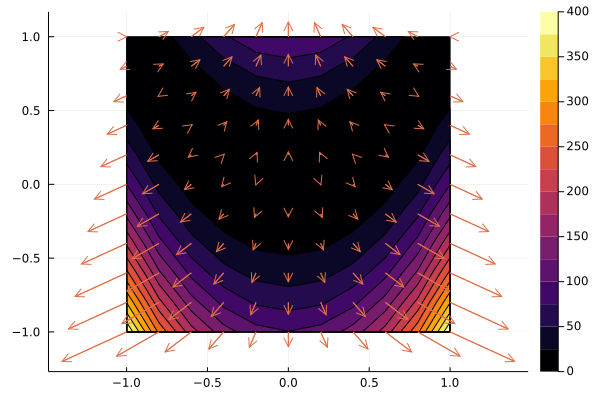

In [28]:
function fval(f, xv, yv)
    x, y = Variable(xv), Variable(yv)
    z = f(x, y)
    value(z)
end

function fgrad(f, xv, yv)
    x, y = Variable(xv), Variable(yv) 
    z = f(x, y)
    backward(z)
    5e-4x.grad, 5e-4y.grad
end

zv = fval.(rosenbrock, xv, yv)
dz = fgrad.(rosenbrock, xv[:], yv[:])

using Plots
zv = reshape(zv, n, n)
contour(v, v, zv, fill=true) 
quiver!(xv[:], yv[:], gradient=dz)